In [2]:
%matplotlib widget

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as ipy
from ipywidgets import fixed

import math
import pandas as pd
import pandas

from silx.io.specfile import SpecFile
import fabio
import pyFAI

from pyFAI.multi_geometry import MultiGeometry
from pyFAI.gui import jupyter
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as AzInt
import scipy.io

from collections import OrderedDict
from natsort import natsorted, os_sorted
import pickle

from scipy.optimize import curve_fit
import scipy.interpolate as interpolate

from xdart.utils import write_xye, write_csv

import warnings
warnings.filterwarnings('ignore')

AA = r'\mathrm{\AA}^{-1}'
cmap='magma'

## Functions

In [11]:
def read_image(file, shape=(195, 487), dtype='int32', header_skip=4096, flip=False, mask=None):
    """
    Generic function to read TIFF and RAW files. Assumes specific structure.
    TIFF files have a header to skip, RAW files don't.
    """
    try:
        with open(file, 'rb') as im:
            if file.suffix in ['tif', 'tiff']:
                im.seek(header_skip)
            arr = np.frombuffer(im.read(), dtype=dtype)
            arr = arr.reshape(shape).astype(float)
        if flip:
            arr = np.fliplr(arr)
        if mask is not None:
            arr[mask] = np.NaN
        return arr
    except Exception as e:
        print(f"Error reading file: {file}, Error: {str(e)}")
        return None


def get_from_spec_file(fname, scan_number, cols):
    scan_data = SpecFile(str(fname))[scan_number - 1]

    spec_data = {}
    for col in cols:
        if col in scan_data.labels:
            spec_data[col] = scan_data.data_column_by_name(col)
        elif col in scan_data.motor_names:
            spec_data[col] = scan_data.motor_position_by_name(col) 
        else:
            print(f'{col} does not exist')
    return spec_data


def get_motor_spec_file(fname, scan_number, motor):
    scan_data = SpecFile(str(fname))[scan_number - 1]
    return scan_data.motor_position_by_name(motor)


def get_del_step(csv_file):
    df = pd.read_csv(csv_file)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.columns = df.columns.str.replace(' ', '')

    try:
        return df['del'].to_numpy()
    except:
        return df['tth'].to_numpy()

def gauss_linbkg(x, m, b, x0, intint, fwhm):
    return m*x + b + intint*(2./fwhm)*np.sqrt(np.log(2.)/np.pi)*np.exp(-4.*np.log(2.)*((x-x0)/fwhm)**2)
    
    
def Gauss_fit(x, y):
    pguess = [0, 0, np.argmax(y), np.max(y), 5.0]  # linear background (2), pos, intensity, fwhm
    popt, pcov = curve_fit(gauss_linbkg, x, y, p0=pguess)
    return popt


def simple_line(x, m, b):
    return m*x + b


def plot_1D_data(ax, x, y, yerr=None, label=None, fmt='.', attrs={}, clear_plot=True, **kwargs):
    """
    Plots data on the given Axes object with optional error bars and attributes.
    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the data.
        x (array-like): The x data.
        y (array-like): The y data.
        yerr (array-like, optional): The error bars for the y data. Defaults to None.
        label (str, optional): The label for the data series. Defaults to None.
        fmt (str, optional): The format string for the data points. Defaults to '.'.
        attrs (dict, optional): A dictionary of attributes to set on the axes. Defaults to {}.
        clear_plot (bool, optional): Whether to clear the plot before plotting. Defaults to True.
        **kwargs: Additional keyword arguments passed to `ax.errorbar`.
    Returns:
        None
    Usage example:
        plot_data(ax, x, y, yerr=y_err, label='Data', fmt='o-', attrs=dict(xscale='linear', yscale='log', xlabel='x', ylabel='y', title='Example Plot'))
    """
    if clear_plot:
        ax.cla()
        
    ax.errorbar(x, y, yerr=yerr, fmt=fmt, label=label, **kwargs)
    ax.set(**attrs)
    if label is not None:
        ax.legend()


def plot_imshow(ax, data, attrs, cax=None, cb_label=None, cb_fontsize=14, clear=True, **kwargs):
    if clear:
        ax.clear()
        
    i1 = ax.imshow(data, **kwargs)
    ax.set(**attrs)
    ax.grid(False)
    
    if cax is not None:
        cb = plt.colorbar(i1, cax=cax, use_gridspec=True)
        cb.set_label(cb_label, fontsize=cb_fontsize)


### Calibration - Get detector distance using Kevin's script

In [4]:
# Useful information for calibration goes here
base_path = Path(r'/Users/vthampy/SSRL_Data/Ashton/May2024')
img_path = base_path / 'images'

calib_name = "b_jaramillo_calibration_scan1_"

csv_path = base_path / 'calibration'
csv_name = "calibration_scan1.csv"
csv_file = csv_path / csv_name
calib_file = csv_path / 'calibration'

db_pixel = [266, 88]  # direct beam pixel
#db_pixel = [487-db_x, db_y]  #This line is important for the way the detector is mounted at BL2-1
pix_size = 172.0  # pixel size in microns

xy = OrderedDict()

Sample to detector distance in pixels = 4122.474269019507
Sample to detector distance in mm = 709.0655742713552


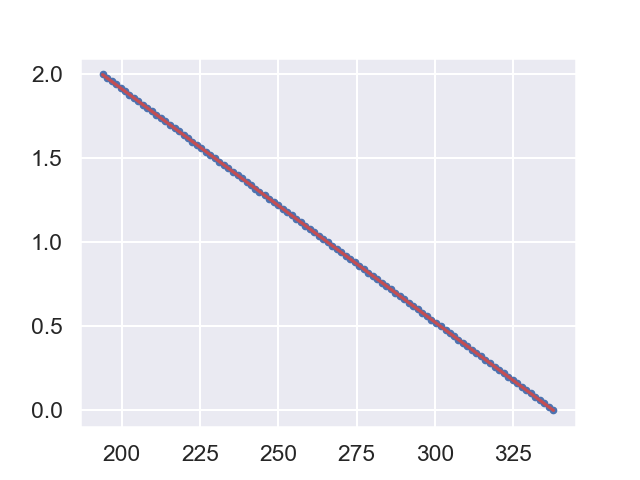

In [5]:
# Read CSV file, get step size and number of points in scan
#x, y, i0 = csvread(csv_path + csv_name)
x = get_del_step(str(csv_file))
num_points = len(x)
calib_tth_steps = x[1] - x[0]
#x, y, i0 = [], [], []

# Read images, take line cut, fit feature position for calibration scan
pks = []
for i in np.arange(0, num_points):
    filename = img_path / f'{calib_name}{i:04d}.raw'
    data = read_image(filename)
    x = np.arange(0, np.shape(data)[1])
    y = data[db_pixel[1], :]
    y += data[db_pixel[1] + 1, :]
    y += data[db_pixel[1] - 1, :]
    y += data[db_pixel[1] + 2, :]
    y += data[db_pixel[1] - 2, :]
    popt = Gauss_fit(x, y)
    pks = np.append(pks, popt[2])

# Fit line to the extracted peak positions and determine the sample to detector distance
x = np.arange(num_points)
lin_fit, pcov = curve_fit(simple_line, pks, x*calib_tth_steps + 0.00)
det_R = 1.0/np.tan(abs(lin_fit[0])*np.pi/180.0)     # sample to detector distance in pixels
print("Sample to detector distance in pixels = " + str(det_R))
print("Sample to detector distance in mm = " + str((det_R * pix_size / 1000.0)))

plt.figure();
plt.plot(pks, x*calib_tth_steps, 'b.');
plt.plot(pks, lin_fit[0]*pks + lin_fit[1], 'r-');

## Initialize paths. 
*  Assumes images are in a subdirectory of the spec-path
*  Assumes export directory exists (try creating one programatically?)
*  Uses spec file to translate detector
*  Only tested for pliatus 100k in horizontal orientation

### Set up pyFAI Integrator

In [6]:
#det_R = 4069.77

# portrait mode?
portrait = True

# define detector.  
det = pyFAI.detectors.Pilatus100k()

# define detector geometry
centerPx1, centerPx2 = db_pixel
rot3 = 0
if portrait:
    centerPx2, centerPx1 = centerPx1, centerPx2
    rot3 = np.pi/2 

distance = det_R * pix_size *1e-6    # meters
en_motor = 'Monochrom'
energy = get_from_spec_file(calib_file, 1, [en_motor])[en_motor]/1e3    # keV 
wavelength = 12.398 / energy * 1e-10  # Angstrom

ai_pars = {
    'detector': det,
    'dist': distance,
    'wavelength': wavelength,
    'poni1': centerPx1*det.pixel1,
    'poni2': centerPx2*det.pixel1,
    'rot3': rot3
}

q = ha* + kb* + lc*

a*, b*, c* = 2pi/a, 2pi/b, 2pi/c

|q| = sqrt(ha*^2 +kb*^2 + lc*^2)

# 111 Peak
h, k, l = 1, 1, 1

|q| = sqrt(3*a*^2)
|q| = sqrt(3*(2pi/a)^2)
|q| = (2pi/a) * sqrt(3)
a = 2pi * sqrt(3)/|q|

# 200 Peak
h, k, l, = 2, 0, 0
|q| = sqrt(4*a*^2)
a = 4pi/|q|

### Paths and Storage Variables

In [7]:
# Name of pickle file to store dictionary
reduced_data_path = base_path / 'reduced_data'
reduced_data_path.mkdir(exist_ok=True)
pickle_file = reduced_data_path / 'reduced_data_1D.pkl'

# Dictionary to store reduced data
if pickle_file.is_file():
    with open(pickle_file, 'rb') as f:
        xy = pickle.load(f)
else:
    xy = OrderedDict()

### Integrate 1D - 2Th Scans

Pd_0p1KOH_0p005HP_N2_0p2deg_full2theta_scan1


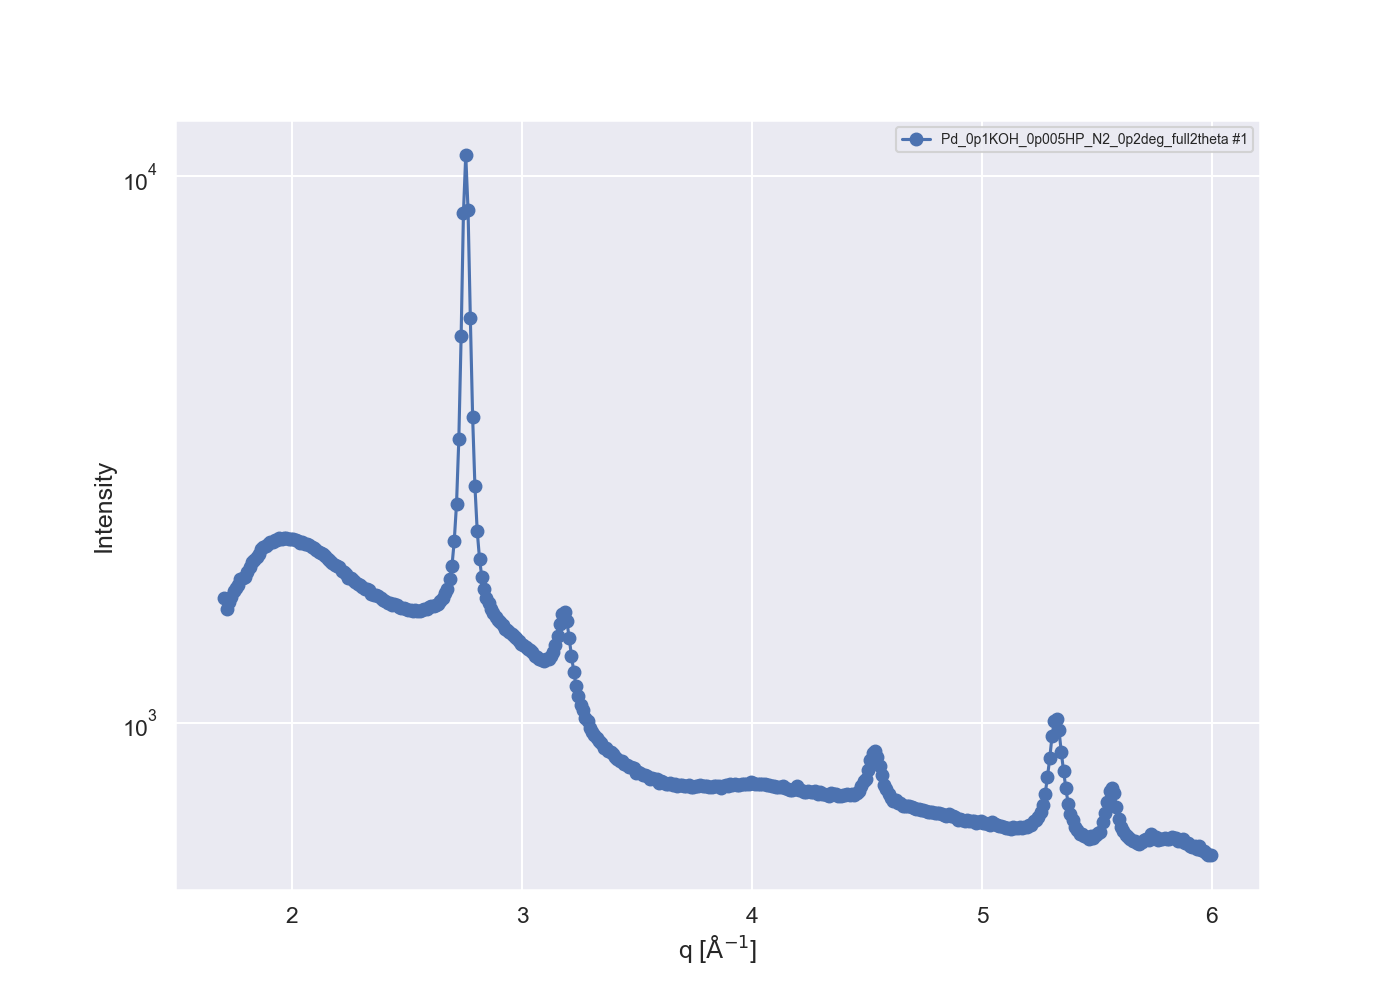

In [ ]:
spec_scans = {
    'Pd_0p1KOH_0p005HP_N2_0p2deg_full2theta' : ('sihe', [1]),    # Put in Specfilename, path of specfile (relative to bse_path), and scan numbers 
}

scans = OrderedDict()
for spec_name, (spec_rpath, scan_nums) in spec_scans.items():
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_name': spec_name,
            'spec_path': base_path / spec_rpath / spec_name,
            'scan_num': scan_num,
            'img_fpaths': os_sorted(list(img_path.glob(f'b_jaramillo_{spec_name}_scan{scan_num}_*.raw'))) 
        }

#######################################################################
###      Start scan information and integration here...
#######################################################################

fig, ax = plt.subplots(1, 1, figsize=(14,10))

# Create Mask (1s are masked out)
lst_mask = np.ones(det.mask.shape)
lst_mask[5:-5, 5:-5] = 0

reprocess = True 
for n, (scan, scan_info)  in enumerate(scans.items()):
    if scan in  xy.keys() and (not reprocess):
        continue
    print(f'\r{scan}')
    # print(f'\r{scan}                                     ', end='\r')

    fname, spec_name = scan_info['spec_path'], scan_info['spec_name']
    scan_num, img_fpaths = scan_info['scan_num'], scan_info['img_fpaths']
    
    cols_dict = get_from_spec_file(str(fname), scan_num, ['tth', 'I0', 'Monitor'])
    tth, i0, i1 = cols_dict['tth'], cols_dict['I0'], cols_dict['Monitor']
    if isinstance(tth, float): tth = [tth]

    imgs, ais = [], []
    # print(len(i1), len(img_fpaths))
    for idx, filename in enumerate(img_fpaths):
        #print(idx)
        data = read_image(filename, flip=False) / i1[idx]
        if data is None:
            continue
            
        imgs.append(data)
        try:
            ais.append(AzInt(**ai_pars, rot1=np.deg2rad(tth[idx])))
        except:
            ais.append(AzInt(**ai_pars, rot1=np.deg2rad(tth[0])))

    #radial_range = [tth[0]-2.2, tth[-1]+2.2]
    radial_range = [1.7, 6]
    num_pts = int((radial_range[1] - radial_range[0]) * 100)
    #mg = MultiGeometry(ais, unit="2th_deg", radial_range=radial_range)#, azimuth_range=(-120,-45)) unit="", 
    mg = MultiGeometry(ais, unit="q_A^-1", radial_range=radial_range)#, azimuth_range=(-120,-45)) unit="2th_deg", 
    int1d = mg.integrate1d(imgs, num_pts, lst_mask=lst_mask, method='bbox')

    label = f'{spec_name} #{scan_num}'
    plot_1D_data(ax, int1d[0], int1d[1], label=label, fmt='o-', attrs=dict(yscale='log', xlabel=rf'q [${AA}$]', ylabel='Intensity'))

    # Write I(Q) to xye
    xye_fname = reduced_data_path / f'{scan}_Itth.xye'
    write_xye(xye_fname, int1d[0], int1d[1], np.sqrt(abs(int1d[1])))

    # Write I(Q) to csv
    csv_fname = reduced_data_path / f'{scan}_Itth.csv'
    write_csv(csv_fname, int1d[0], int1d[1], np.sqrt(abs(int1d[1])))

    xy[scan] = (str(fname), scan_num,  int1d[0], int1d[1])

ax.legend(fontsize=10);

with open(str(pickle_file), 'wb') as f:
    pickle.dump(xy, f)

### Integrate 1D - Loop Scans

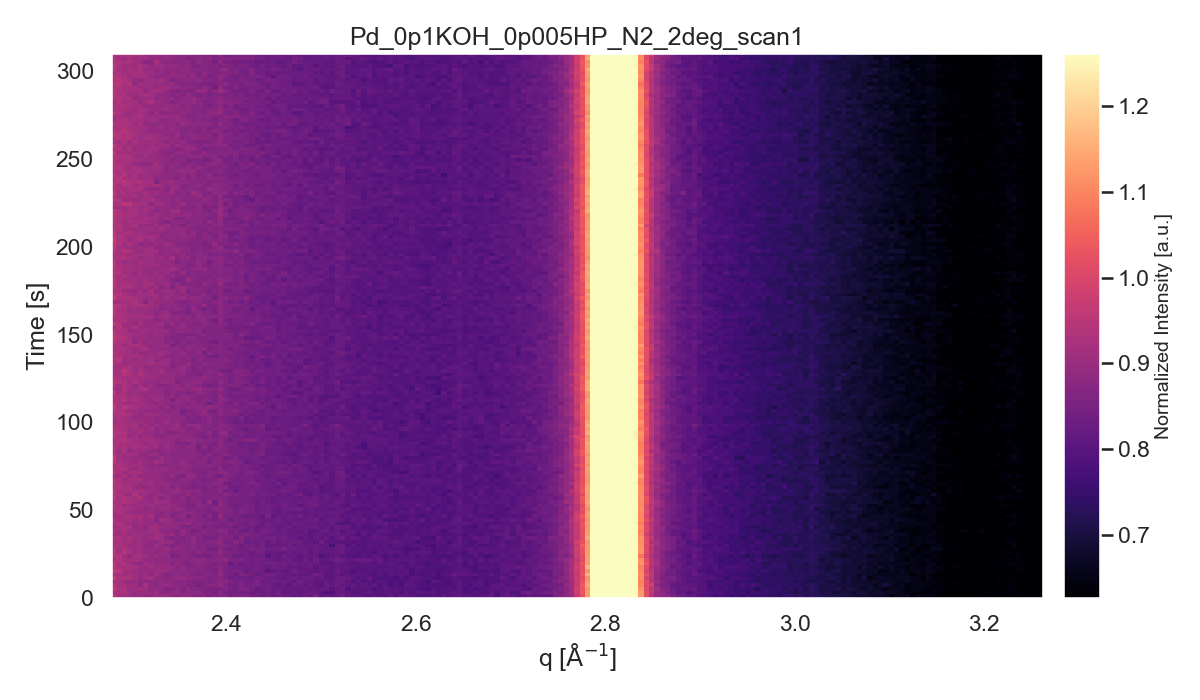

In [ ]:
spec_scans = {
    'Pd_0p1KOH_0p005HP_N2_2deg' : ('sihe', [1]),    # Put in Specfilename, path of specfile (relative to bse_path), and scan numbers 
}

scans = OrderedDict()
for spec_name, (spec_rpath, scan_nums) in spec_scans.items():
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_name': spec_name,
            'spec_path': base_path / spec_rpath / spec_name,
            'scan_num': scan_num,
            'img_fpaths': os_sorted(list(img_path.glob(f'b_jaramillo_{spec_name}_scan{scan_num}_*.raw'))) 
        }

#######################################################################
###      Start scan information and integration here...
#######################################################################

f2, f2_ax1 = plt.subplots(ncols=1, figsize=(12, 7), layout='tight')
divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes('right', size='4%', pad=0.2)


# Create Mask (1s are masked out)
lst_mask = np.ones(det.mask.shape)
lst_mask[5:-5, 5:-5] = 0

reprocess = True 
for n, (scan, scan_info)  in enumerate(scans.items()):
    if scan in  xy.keys() and (not reprocess):
        continue
    print(f'\r{scan}                                     ', end='\r')

    fname, spec_name = scan_info['spec_path'], scan_info['spec_name']
    scan_num, img_fpaths = scan_info['scan_num'], scan_info['img_fpaths']
    
    cols_dict = get_from_spec_file(str(fname), scan_num, ['tth', 'I0', 'Monitor', 'Time'])
    tth, i0, i1, t = cols_dict['tth'], cols_dict['I0'], cols_dict['Monitor'], cols_dict['Time']
    if isinstance(tth, float): tth = np.zeros_like(i1) + tth

    imgs, iq = [], []
    for idx, filename in enumerate(img_fpaths):
        data = read_image(filename, flip=False) / i1[idx]*1e4
        ai = AzInt(**ai_pars, rot1=np.deg2rad(tth[idx]))
        
        
        radial_range = [tth[0]-2.2, tth[-1]+2.2]
        num_pts = int((radial_range[1] - radial_range[0]) * 40)
        int1d = ai.integrate1d(data, num_pts,  unit="q_A^-1", mask=lst_mask, method='bbox')
        iq.append(int1d[1])

        # Write I(Q) to xye
        xye_fname = reduced_data_path / f'{scan}_{idx}_Iq.xye'
        write_xye(xye_fname, int1d[0], int1d[1], np.sqrt(abs(int1d[1])))

        # Write I(Q) to csv
        csv_fname = reduced_data_path / f'{scan}_{idx}_Iq.csv'
        write_csv(csv_fname, int1d[0], int1d[1], np.sqrt(abs(int1d[1])))

    q, iq = np.array(int1d[0]), np.array(iq)
    vminmax = np.nanpercentile(iq, (5, 95))
    plot_imshow(f2_ax1, iq, extent=(q[0], q[-1], 0, t[-1] - t[0]), origin='lower', aspect='auto', cmap=cmap, vmin=vminmax[0], vmax=vminmax[1],
                cax=f2_cax1, cb_label='Normalized Intensity [a.u.]',
                attrs={'ylabel': 'Time [s]', 'xlabel': rf'q [${AA}$]', 'title': rf'{scan}'})

    xy[scan] = (str(fname), scan_num,  q, iq)

with open(str(pickle_file), 'wb') as f:
    pickle.dump(xy, f)

## Plot Reduced Data

interactive(children=(Dropdown(description='Scan', index=4, options=('50nmPd_3nmTi_Si_dry_XRR_scan1', '50nmPd_…

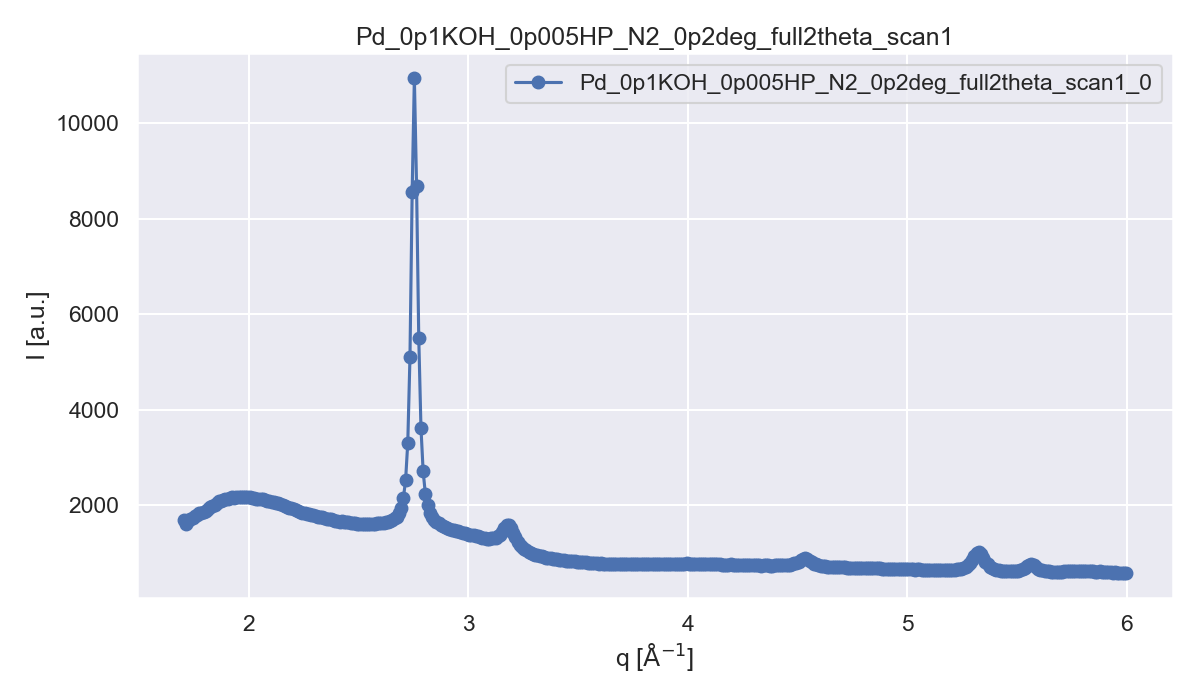

In [18]:
fig2, ax2 = plt.subplots(ncols=1, figsize=(12, 7))

labels = []
processed_scans = list(xy.keys())
#xlim_widget = ipy.FloatRangeSlider(min=0, max=70, value=(1.4, 4.4), step=0.005)
#xlim_widget = ipy.FloatRangeSlider(step=0.1)
NSlider = ipy.IntSlider(min=0, max=1, step=1, value=0)

@ipy.interact(
    Scan=ipy.Dropdown(options=processed_scans, value=processed_scans[-1]),
    N=NSlider,
    xaxis=ipy.Dropdown(options=['q', 'tth'], value='q'),
    log=False,
    #xlim=xlim_widget,
    overlay=False
)
# def show_iq(Scan, xaxis, xlim, log, overlay):
def show_iq(Scan, N, xaxis, log, overlay):
    if not overlay:
        ax2.cla()
        labels.clear()
    ax2.grid(True)
    
    fname, scan_num, q, iq = xy[Scan]
    # q = 4 * np.pi * energy / 12.398 * np.sin(np.deg2rad(tth)/2)
    tth = 2 * np.rad2deg( np.arcsin( 12.398 / (4 * np.pi * energy) * q) )

    if iq.ndim > 1:
        NSlider.max = len(iq)
        i_q = iq[N]
    else:
        NSlider.max = 0
        i_q = iq
        
    x, xlabel = q, f'q [${AA}$]'
    if xaxis == 'tth':
        x, xlabel = tth, rf'2$\theta$ [$^o$]'
    #xlim_widget.value = (x.min(), x.max())

    if f'{Scan}_{N}' not in labels:
        plot_1D_data(ax2, x, i_q, label=f'{Scan}_{N}', fmt='o-', clear_plot=False,
                     attrs=dict(xlabel=xlabel, ylabel='I [a.u.]', yscale='log' if log else 'linear', title=f'{Scan}'))
        labels.append(f'{Scan}_{N}')
        
    fig2.tight_layout()

## Show Raw Images

interactive(children=(Dropdown(description='scan', options=('Be_RT_scan1',), value='Be_RT_scan1'), IntSlider(v…

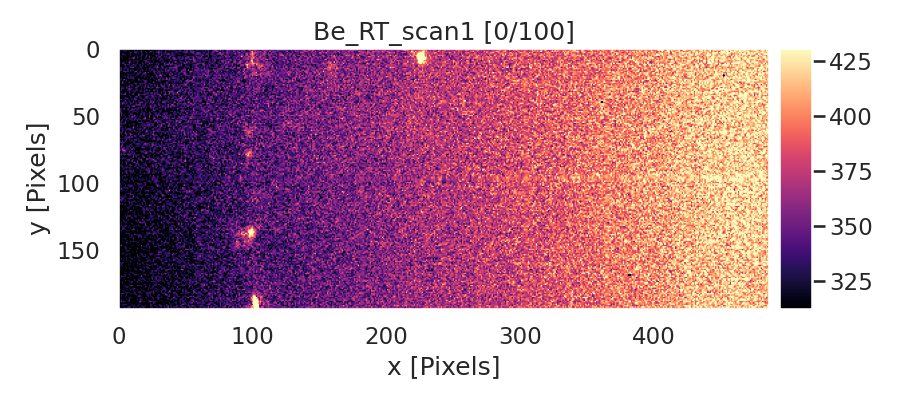

In [93]:
def show_raw_image(scan, n, vminmax, ax, cax):
    im_files = scans[scan]['img_fpaths'] 
    n_ims = len(im_files)
    if n_ims == 0:
        ax.cla()
        ax.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_arr = read_image(im_files[n])
    
    minmax = np.nanpercentile(im_arr, vminmax)
    i1 = ax.imshow(
        im_arr, cmap=cmap, origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax.set_xlabel('x [Pixels]')
    ax.set_ylabel('y [Pixels]')
    ax.set_title(f'{scan} [{n}/{n_ims-1}]')
    ax.grid(False)
    
    cb1 = plt.colorbar(i1, cax=cax, use_gridspec=True)


f1, f1_ax1 = plt.subplots(figsize=(9, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

all_scans = list(scans.keys())
scan = all_scans[-1]
scan_widget = ipy.Dropdown(options=all_scans, value=scan)

nimage_widget = ipy.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipy.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

ipy.interact(show_raw_image, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget, ax=fixed(f1_ax1), cax=fixed(f1_cax1));

In [ ]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_04_McIntyre')
img_path = base_path / 'images'

spec_scans = {
    'Be_RT': ('samples', [1]), 
    'TiN_200C': ('TiN_200C', [2] + list(range(3,23))),
    'TiN_250C_10nm_RT': ('samples', [1, 3]),
    'TiN_200C_RT': ('samples', [1, 2, 3]),
    'TiN_200C_RT_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_RT_April2': ('samples', [1,2,3]),
    'TiN_200C_12p5K_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_12p5K_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_15K_April2': ('samples', [1, 2, 3]),
    'TiN_200C_15K_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_15K_April2_short': ('samples', [1, 2]),
    'TiN_200C_15K_April2_short': ('samples', [1, 2]),
    'TiN_250C_10nm_20K_April2': ('samples', [1, 2, 3]),
    'TiN_200C_20K_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_20K_April2_short': ('samples', [1, 2]),
    'TiN_200C_20K_April2_short': ('samples', [1, 2]),
    'TiN_250C_10nm_35K_April2': ('samples', [1, 2, 3]),
    'TiN_200C_35K_April2': ('samples', [1, 2, 3]),
    'TiN_250C_10nm_35K_April2_short': ('samples', [1, 2]),
    'TiN_200C_35K_April2_short': ('samples', [1, 2]),
    'TiN_200C_50K_April2': ('samples', [1,2,3]),
    'TiN_200C_50K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_50K_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_50K_April2_short': ('samples', [1,2]),
    'TiN_200C_77K_April2': ('samples', [1,2,3]),
    'TiN_200C_77K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_77K_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_77K_April2_short': ('samples', [1,2]),
    'TiN_200C_100K_April2': ('samples', [1,2,3]),
    'TiN_200C_100K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_100K_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_100K_April2_short': ('samples', [1,2]),
     'TiN_200C_150K_April2': ('samples', [1,2,3]),
    'TiN_200C_150K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_150K_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_150K_April2_short': ('samples', [1,2]),
    'TiN_200C_200K_April2': ('samples', [1,2,3]),
    'TiN_200C_200K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_200K_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_200K_April2_short': ('samples', [1,2]),
    'TiN_200C_250K_April2': ('samples', [1,2,3]),
    'TiN_200C_250K_April2_short': ('samples', [1,2]),
    'TiN_250C_10nm_250K_April2': ('samples', [1,]),
    'TiN_250C_10nm_250K_April2_short': ('samples', [1,2]),
    'TiN_200C_296K_end_April2': ('samples', [1,2,3]),
    'TiN_250C_10nm_296K_end_April2': ('samples', [1,2,3]),
    'TiN_200C_296K_end_point2_April2': ('samples', [1]),
    'Mo_4nm_296K_start_April3': ('samples', [1, 2,3]),
    'Mo_10nm_296K_start_April3': ('samples', [1, 2,3]),
    'Mo_10nm_296K_start_April3_BeTest': ('samples', [2, 3, 6]),
    'Mo_10nm_15K_start_April3': ('samples', [1, 2]),
    'Mo_4nm_15K_start_April3': ('samples', [1])
    
}

#######################################################################
###      Start scan information and integration here...
#######################################################################

fig, ax = plt.subplots(1, 1, figsize=(14,10))

lst_mask = np.ones(det.mask.shape)
lst_mask[5:-5, 50:450] = 0
#lst_mask[:, :] = 0

reprocess = True
for spec_name, (spec_folder, scan_numbers) in spec_scans.items():
    spec_path = base_path / spec_folder
    fname = spec_path / spec_name
    for scan_num in scan_numbers:
        dict_key = f'{spec_name} #{scan_num}'
        if (dict_key in xy.keys()) and (not reprocess):
            continue
        print(dict_key)
    
        # print(scan_num)
        cols_dict = get_from_spec_file(str(fname), scan_num, ['del', 'i0', 'i1'])
        tth, i0, i1 = cols_dict['del'], cols_dict['i0'], cols_dict['i1']

        imgs = []
        ais = []

        for k in range(1, len(tth)):
            filename = next(img_path.glob(f'*{spec_name}_scan{scan_num}_{k:04}.raw'))
            # print('\r', filename, end='\r')
            data = read_image(filename, flip=True) / i1[k-1]

            imgs.append(data)
            ai = AzInt(dist=distance, poni1=centerPx1*det.pixel1, poni2=centerPx2*det.pixel1, detector=det, 
                   wavelength=wavelength, rot1=np.pi/180*float(tth[k-1]), rot3=rot3)
            ais.append(ai)
   
        mg = MultiGeometry(ais, unit="q_A^-1", radial_range=(1.5, 4.3))#, azimuth_range=(-120,-45))
        int1d = mg.integrate1d(imgs, 3000, lst_mask=lst_mask)

        xy[dict_key] = (fname, scan_num,  int1d[0], int1d[1])
        
        ax.plot(int1d[0], int1d[1], label=f'{spec_name} #{scan_num}')
        ax.set_yscale('log')
        ax.set_ylabel('Intensity')

ax.legend();

Mo_4nm_15K_start_April3 #1


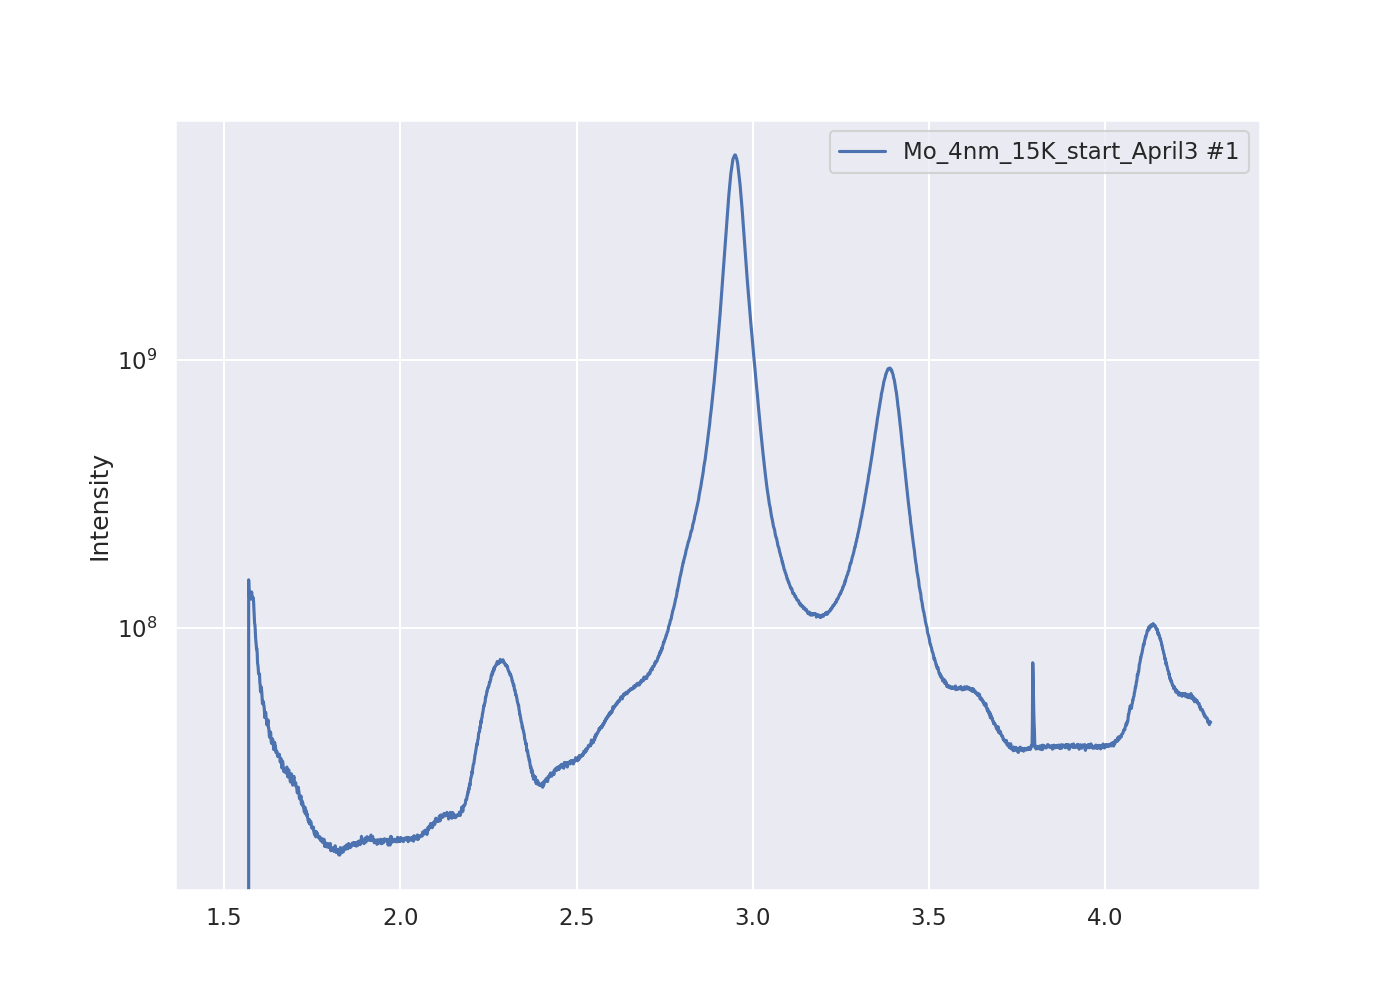

In [47]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_04_McIntyre')
img_path = base_path / 'images'

spec_scans = {
    'Mo_4nm_15K_start_April3': ('samples', [1])
}

#######################################################################
###      Start scan information and integration here...
#######################################################################

fig, ax = plt.subplots(1, 1, figsize=(14,10))

lst_mask = np.ones(det.mask.shape)
lst_mask[5:-5, 50:450] = 0
#lst_mask[:, :] = 0

reprocess = True
for spec_name, (spec_folder, scan_numbers) in spec_scans.items():
    spec_path = base_path / spec_folder
    fname = spec_path / spec_name
    for scan_num in scan_numbers:
        dict_key = f'{spec_name} #{scan_num}'
        if (dict_key in xy.keys()) and (not reprocess):
            continue
        print(dict_key)
    
        # print(scan_num)
        cols_dict = get_from_spec_file(str(fname), scan_num, ['del', 'i0', 'i1'])
        tth, i0, i1 = cols_dict['del'], cols_dict['i0'], cols_dict['i1']

        imgs, ais = [], []

        for k in range(1, len(tth)):
            filename = next(img_path.glob(f'*{spec_name}_scan{scan_num}_{k:04}.raw'))
            # print('\r', filename, end='\r')
            data = read_image(filename, flip=True) / i1[k-1]

            imgs.append(data)
            #ai = AzInt(dist=distance, poni1=centerPx1*det.pixel1, poni2=centerPx2*det.pixel1, detector=det, 
            #       wavelength=wavelength, rot1=np.pi/180*float(tth[k-1]), rot3=rot3)
            #ais.append(ai)
            ais.append(AzInt(**ai_pars, rot1=np.deg2rad(tth[k-1])))

   
        mg = MultiGeometry(ais, unit="q_A^-1", radial_range=(1.5, 4.3))#, azimuth_range=(-120,-45))
        int1d = mg.integrate1d(imgs, 3000, lst_mask=lst_mask)

        xy[dict_key] = (fname, scan_num,  int1d[0], int1d[1])
        
        ax.plot(int1d[0], int1d[1], label=f'{spec_name} #{scan_num}')
        ax.set_yscale('log')
        ax.set_ylabel('Intensity')

ax.legend();

interactive(children=(Dropdown(description='Scan', index=4, options=('Mo_10nm_296K_start_April3 #3', 'Mo_10nm_…

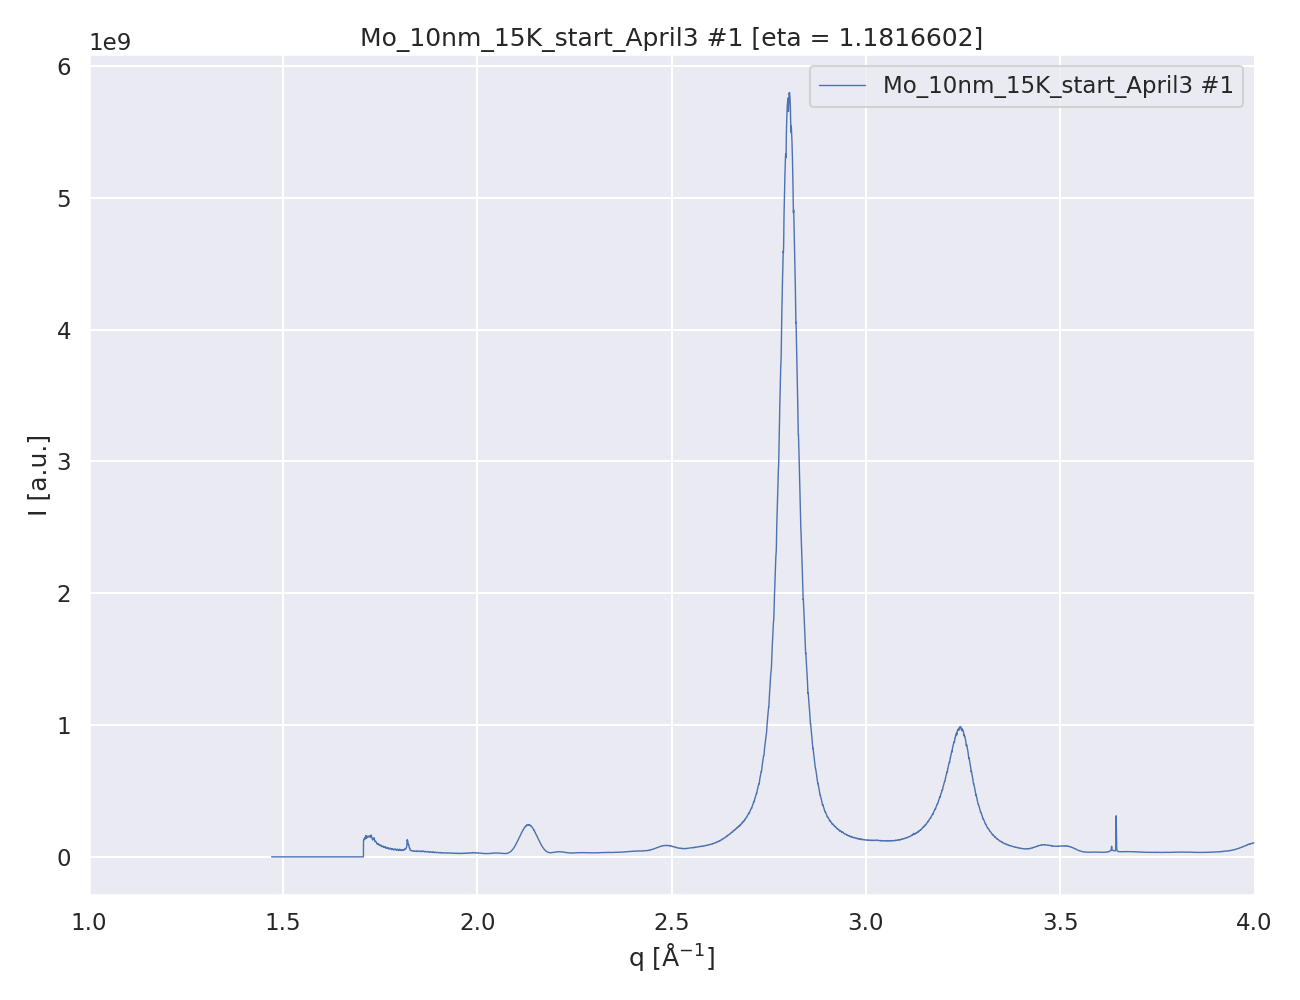

In [16]:
fig2, ax2 = plt.subplots(ncols=1, figsize=(13, 10))

energy = 7.605 # keV

labels = []
processed_scans = list(xy.keys())
xlim_widget = ipy.FloatRangeSlider(min=0, max=70, value=(1, 4), step=0.1)
#xlim_widget = ipy.FloatRangeSlider(step=0.1)
#NSlider = ipy.IntSlider(min=1, max=2, step=1, value=0)

@ipy.interact(Scan=ipy.Dropdown(options=processed_scans, value=processed_scans[-1]),
          xaxis=ipy.Dropdown(options=['q', 'tth'], value='q'),
          log=False,
          xlim=xlim_widget,
          overlay=False
         )
def show_iq(Scan, xaxis, xlim, log, overlay):
    if not overlay:
        ax2.cla()
        labels.clear()
    ax2.grid(True)
    
    fname, scan_num, tth, i_q = xy[Scan]
    q = 4 * np.pi * energy / 12.398 * np.sin(np.deg2rad(tth)/2)

    x, xlabel = q, f'q [${AA}$]'
    if xaxis == 'tth':
        x, xlabel = tth, rf'2$\theta$ [degrees]'
    xlim_widget.value = (x.min(), x.max())

    #scan_num = int(Scan[Scan.rfind('#')+1:])
    eta_val = get_from_spec_file(fname, scan_num, ['eta'])['eta']
    
    if Scan not in labels:
        ax2.plot(x, i_q, '-', ms=4, lw=1, label=Scan)
        labels.append(Scan)
    
    ax2.set_xlim(xlim)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('I [a.u.]')
    if log:
        ax2.set_yscale('log')
        ax2.set_ylabel('log(I) [a.u.]')
        
    ax2.set_title(f'{Scan} [eta = {eta_val}]')
    ax2.legend()
    
    fig2.tight_layout()

Mo_10nm_296K_start_April3_BeTest #2
Mo_10nm_296K_start_April3_BeTest #3


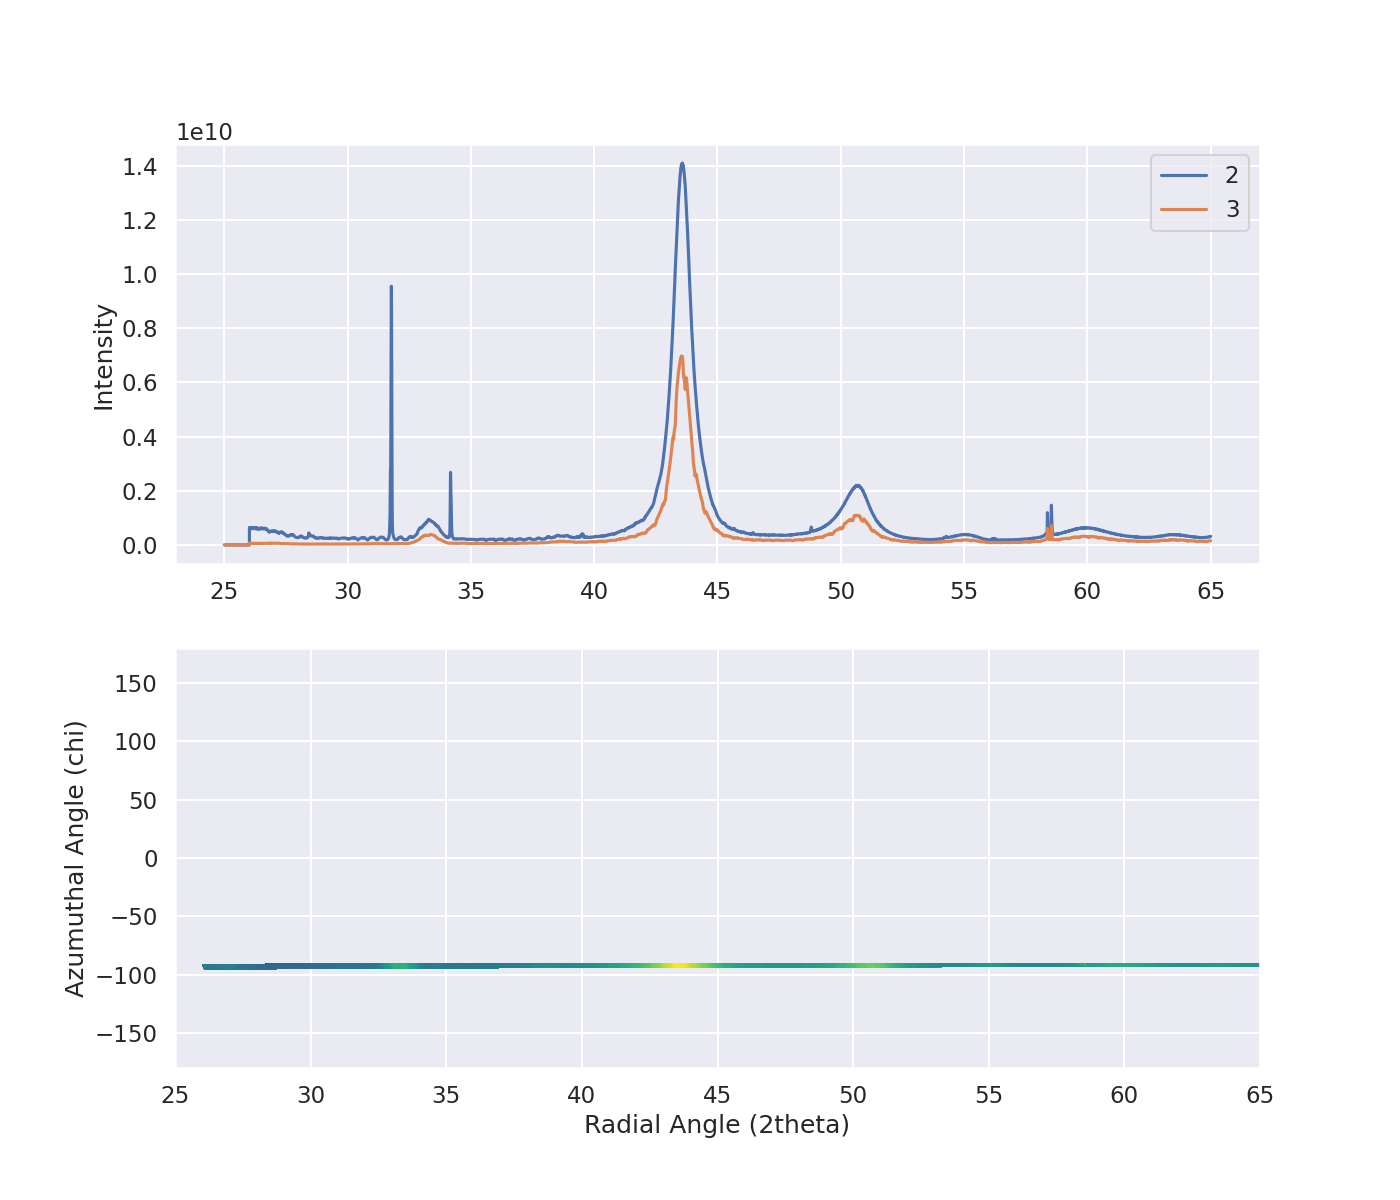

In [58]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_04_McIntyre')
img_path = base_path / 'images'

spec_folder = 'samples'
spec_path = base_path / spec_folder

spec_scans = {
    # 'Be_RT': ('samples', [1]), 
    'Mo_10nm_296K_start_April3_BeTest': ('samples', [2, 3]),
}

#######################################################################
###      Start scan information and integration here...
#######################################################################

fig, axs = plt.subplots(2, 1, figsize=(14,12))

lst_mask = det.mask
lst_mask[:, :] = 1
#lst_mask[:, 450:] = 1

for spec_name, (spec_folder, scan_numbers) in spec_scans.items():
    spec_path = base_path / spec_folder
    fname = spec_path / spec_name
    for scan_num in scan_numbers:
        dict_key = f'{spec_name} #{scan_num}'
        #if dict_key in xy.keys():
        #    continue
        print(dict_key)
    
        # print(scan_num)
        cols_dict = get_from_spec_file(str(fname), scan_num, ['del', 'i0', 'i1'])
        tth, i0, i1 = cols_dict['del'], cols_dict['i0'], cols_dict['i1']

        imgs = []
        ais = []

        for k in range(1, len(tth)):
            filename = next(img_path.glob(f'*{spec_name}_scan{scan_num}_{k:04}.raw'))
            # print('\r', filename, end='\r')
            data = read_image(filename, flip=True)#, mask=)

            imgs.append(data)
            ai = AzInt(dist=distance, poni1=centerPx1*det.pixel1, poni2=centerPx2*det.pixel1, detector=det, 
                   wavelength=wavelength, rot1=np.pi/180*float(tth[k-1]), rot3=rot3)
                   #wavelength=wavelength, rot1=np.pi/180*float(spec['TwoTheta'][scanNo]), rot3=rot3)
            ais.append(ai)
   
        mg = MultiGeometry(ais, unit="2th_deg", radial_range=(25, 65))#, azimuth_range=(-120,-45))
        int1d = mg.integrate1d(imgs, 10000, lst_mask=lst_mask)

        xy[dict_key] = (fname, scan_num,  int1d[0], int1d[1])
        
        axs[0].plot(int1d[0], int1d[1], label=f'{scan_num}')
        axs[0].set_ylabel('Intensity')

        res2d = mg.integrate2d(imgs, 1000, 360)
        # gives 3 arrays.  First is intensities with shape (arg2, arg1)  Second is 2th range, third is azimuthal range

        axs[1].pcolormesh(res2d[1], res2d[2], np.log(res2d[0]), cmap = 'viridis')

        axs[1].set_xlim(25, 65)
        axs[1].set_xlabel('Radial Angle (2theta)')

        axs[1].set_ylabel('Azumuthal Angle (chi)')

axs[0].legend();

In [27]:
testPath = os.path.join(imgPath, 'b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw')
print(testPath)
img = load_image(testPath)
plt.imshow(np.rot90(img, k=-1))
plt.scatter(95, 237, c='r')

C:\Users\roberttk\Desktop\SLAC_RA\DATA\2-1_calibration_test\JL02\images\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\2-1_calibration_test\\JL02\\images\\b_mehta_calibration_directbeam_4Nov2020_scan1_0050.raw'

In [1]:
%matplotlib widget

import numpy as np
import plotly.graph_objects as go

# Example data
x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)
intensity = np.random.rand(100)

# Plotting
fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z, mode='markers',
    marker=dict(size=5, color=intensity, colorscale='Viridis', colorbar=dict(title='Intensity'))
)])
fig.update_layout(title='3D Scatter Plot')
fig.show()

In [ ]:
import numpy as np
from mayavi import mlab

/Users/vthampy/mc/envs/xdart_py311/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


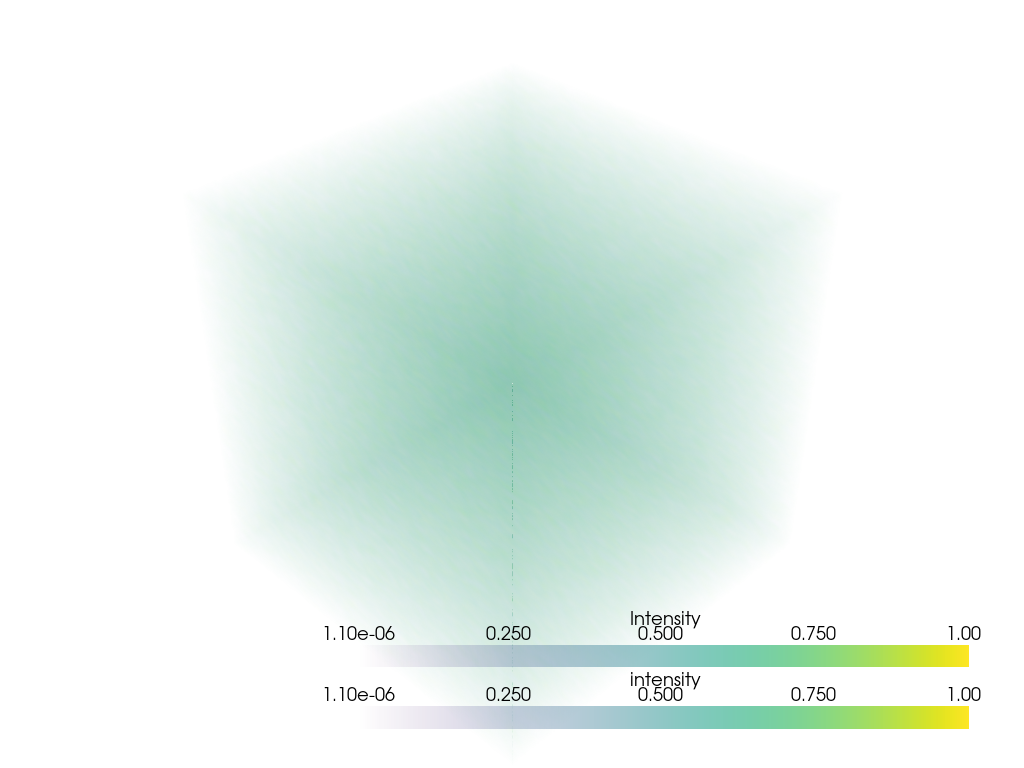

In [1]:
%matplotlib widget
import numpy as np
import pyvista as pv

# Example data
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 40)
z = np.linspace(0, 1, 100)
intensity = np.random.rand(200, 40, 100)

# Create a PyVista structured grid
grid = pv.StructuredGrid(*np.meshgrid(x, y, z, indexing='ij'))
grid["intensity"] = intensity.flatten()

# Plotting
plotter = pv.Plotter(notebook=True)
plotter.add_volume(grid, scalars='intensity', cmap='viridis', opacity='linear')
plotter.add_scalar_bar(title='Intensity')
plotter.show()